## ARIMA and LSTM Model Fine Tuning
This notebook used to sandboxing and perform Exploratory Data Analysis for the IoT dataset that we've downloaded from Kaggle. In this notebook, we also want to fine tune the model to reach the best parameters before implement it in the real dataset.

In [1]:
# Import library
import numpy as np
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import dataset and read as dataframe
import os

file_path = "C:/Kuliah/Semester 6/Signal Processing and Multimedia Services/Project/pslm-project/data/esp32_1_data.csv"

if os.path.exists(file_path):
  df = pd.read_csv(file_path)
else:
  print("File not found!")

# Print top 5 rows of the dataset
df.head()

,timestamp,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm)
0,2025-05-12 | 10:14:13,28.3,81.5,0.242920,0.054,0.0,-61
1,2025-05-12 | 10:14:15,28.5,80.2,0.336914,0.054,0.0,-61
2,2025-05-12 | 10:14:17,28.5,80.2,0.206543,0.054,0.0,-62
3,2025-05-12 | 10:14:19,28.5,80.2,0.434326,0.054,0.0,-65
4,2025-05-12 | 10:14:21,28.5,80.2,0.428711,0.054,0.0,-55


### Data Preprocessing

In [3]:
# Change the time column to datetime format and split it into date and time
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d | %H:%M:%S")

# Resample using timestamp and take the mean of each minute
df = df.set_index("timestamp")
df_resampled = df.resample("min").mean()

In [4]:
# Reset index to get timestamp back as a column
df_resampled = df_resampled.reset_index()

# Check the shape of the dataset
print(f"Dataset shape after resampling: {df_resampled.shape}")

# Check the null values
print(f"Null values in the dataset after resampling\n{df_resampled.isnull().sum()}")

Dataset shape after resampling: (1896, 7)
Null values in the dataset after resampling
timestamp                  0
temperature              117
humidity(%)              117
latency(ms)              117
throughput(bytes/sec)    117
packet_loss(%)           117
rssi(dBm)                117
dtype: int64


In [5]:
# Set time column as index
df_resampled.set_index("timestamp", inplace=True)

In [6]:
# Imputate the null values with the mean of the column
df_resampled.fillna(df_resampled.mean(), inplace=True)

# Check the null values
print(f"Null values in the dataset after imputating\n{df_resampled.isnull().sum()}")

Null values in the dataset after imputating
temperature              0
humidity(%)              0
latency(ms)              0
throughput(bytes/sec)    0
packet_loss(%)           0
rssi(dBm)                0
dtype: int64


In [7]:
# Reset the time index
df_resampled.reset_index(inplace=True)

In [8]:
# Convert the timestamp to time string
df_resampled["time_str"] = df_resampled["timestamp"].dt.strftime("%H:%M")

# Set the time_str as index
df_resampled.set_index("timestamp", inplace=True)

In [19]:
# Show the data in 24 Hours from 12:00:00 to 12:00:00
df_day_one = df_resampled.loc["2025-05-12 12:00:00":"2025-05-13 12:00:00"]
df_day_one

,temperature,humidity(%),latency(ms),throughput(bytes/sec),packet_loss(%),rssi(dBm),time_str
timestamp,,,,,,,
2025-05-12 12:00:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011,12:00
2025-05-12 12:01:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011,12:01
2025-05-12 12:02:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011,12:02
2025-05-12 12:03:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011,12:03
2025-05-12 12:04:00,30.909752,74.027475,0.277156,0.054,0.0,-57.561011,12:04
...,...,...,...,...,...,...,...
2025-05-13 11:56:00,31.182609,67.817391,0.283585,0.054,0.0,-55.869565,11:56
2025-05-13 11:57:00,31.200000,67.974074,0.261457,0.054,0.0,-60.370370,11:57
2025-05-13 11:58:00,31.192308,68.092308,0.296575,0.054,0.0,-58.576923,11:58


### Data Visualization

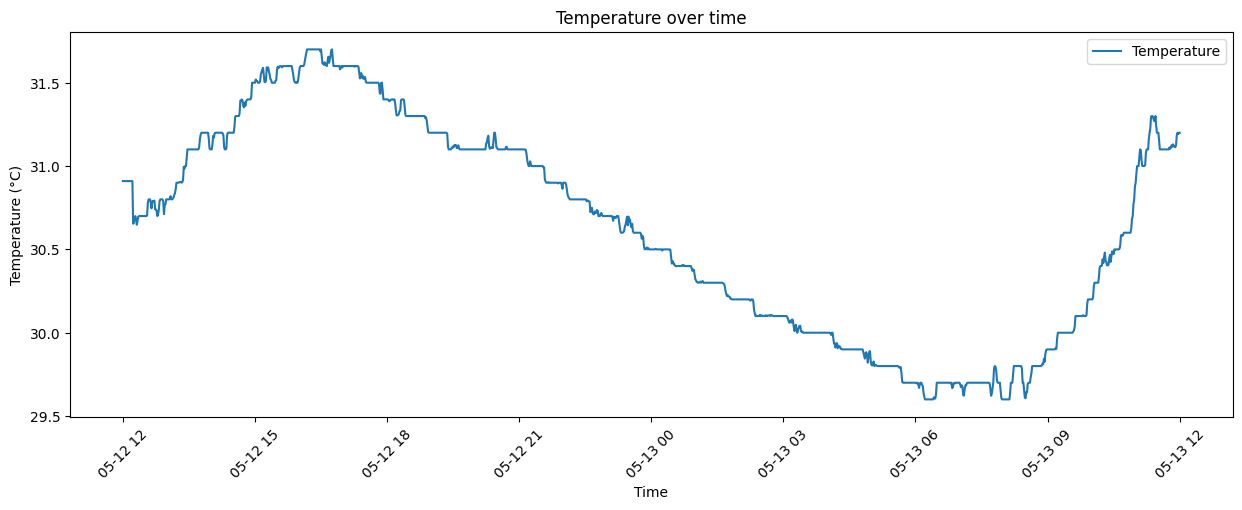

In [10]:
# Plot the temperature over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="temperature", label="Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature over time")
plt.xticks(rotation=45)
plt.show()

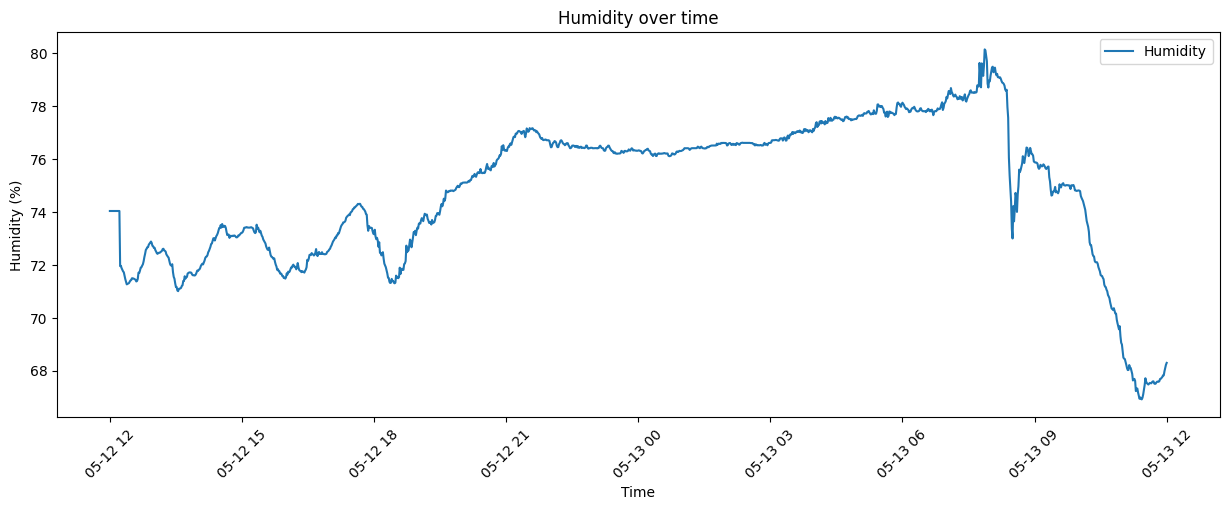

In [11]:
# Plot the humidity over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="humidity(%)", label="Humidity")
plt.xlabel("Time")
plt.ylabel("Humidity (%)")
plt.title("Humidity over time")
plt.xticks(rotation=45)
plt.show()

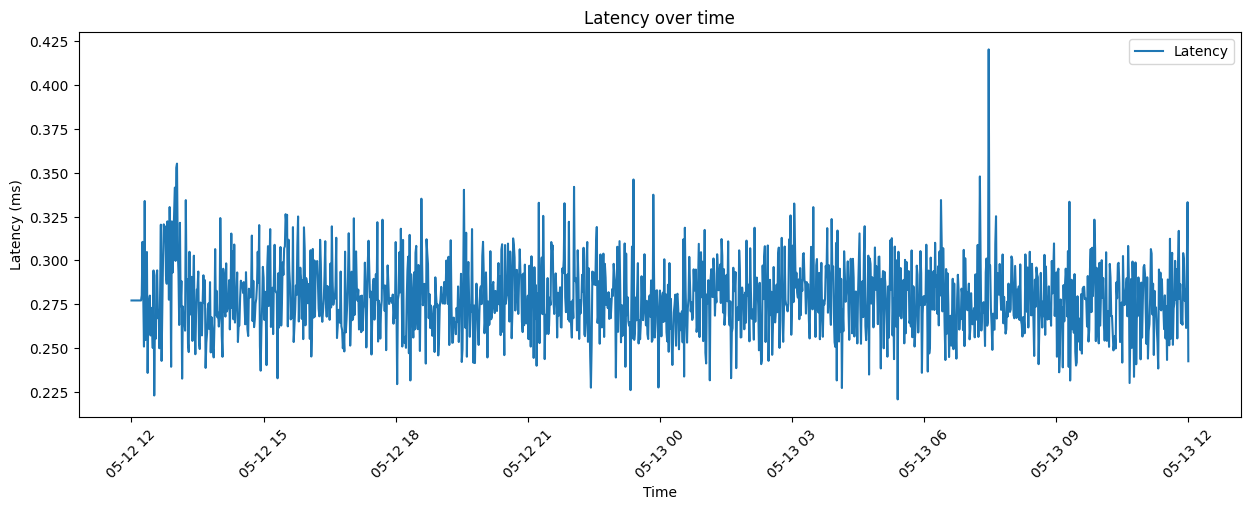

In [12]:
# Plot the latency over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="latency(ms)", label="Latency")
plt.xlabel("Time")
plt.ylabel("Latency (ms)")
plt.title("Latency over time")
plt.xticks(rotation=45)
plt.show()

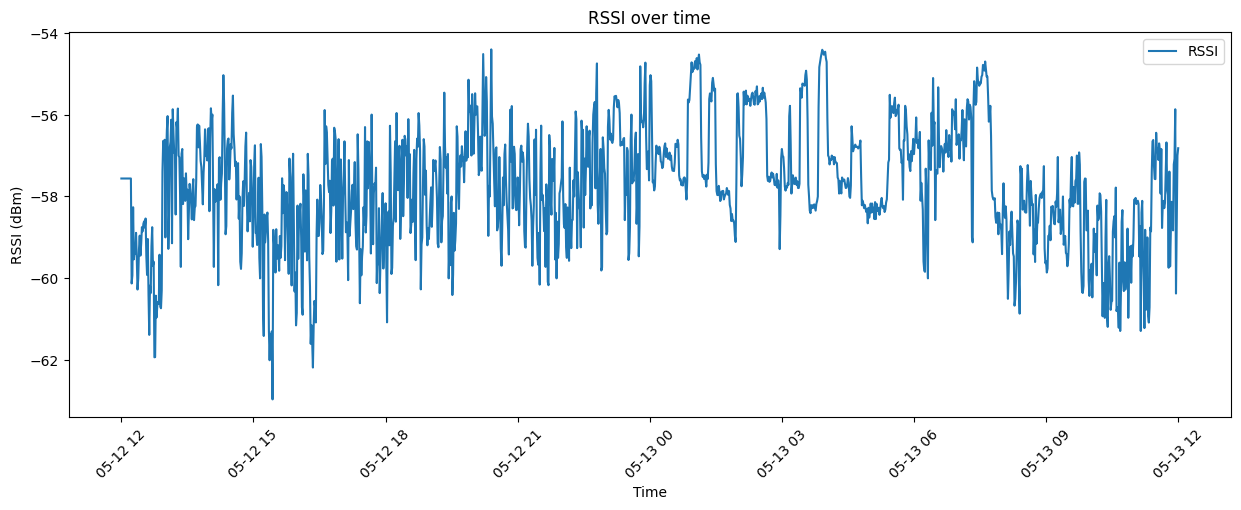

In [13]:
# Plot the RSSI over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="rssi(dBm)", label="RSSI")
plt.xlabel("Time")
plt.ylabel("RSSI (dBm)")
plt.title("RSSI over time")
plt.xticks(rotation=45)
plt.show()

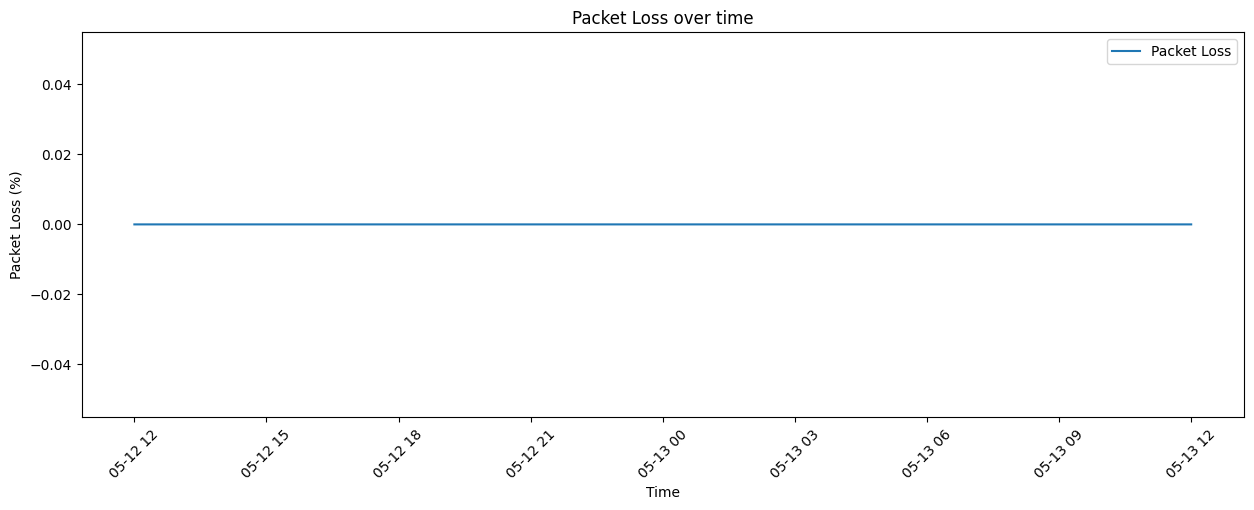

In [14]:
# Plot the RSSI over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="packet_loss(%)", label="Packet Loss")
plt.xlabel("Time")
plt.ylabel("Packet Loss (%)")
plt.title("Packet Loss over time")
plt.xticks(rotation=45)
plt.show()

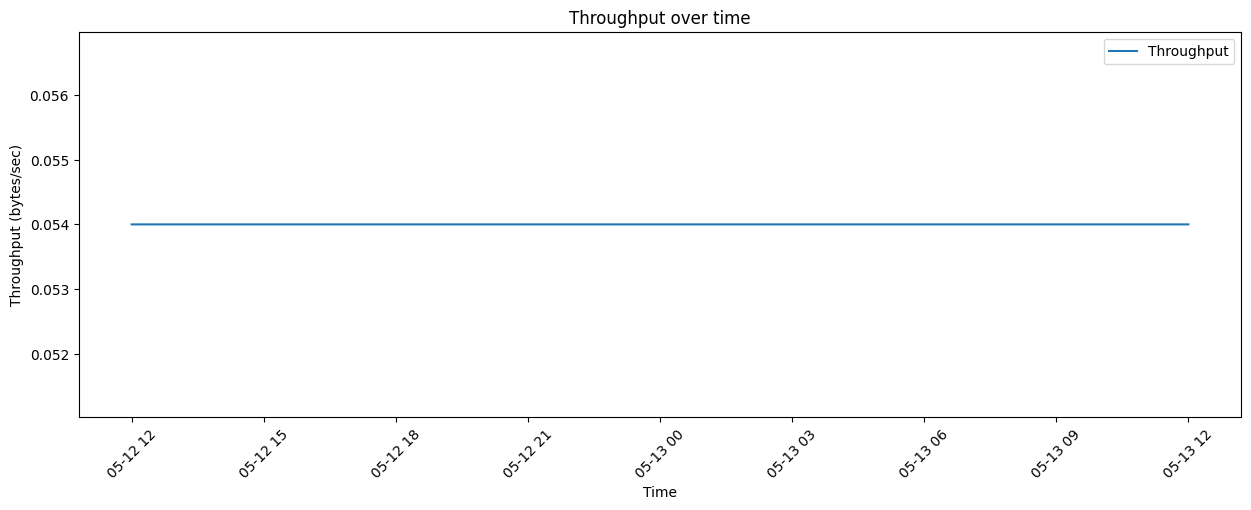

In [15]:
# Plot the RSSI over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_day_one, x=df_day_one.index, y="throughput(bytes/sec)", label="Throughput")
plt.xlabel("Time")
plt.ylabel("Throughput (bytes/sec)")
plt.title("Throughput over time")
plt.xticks(rotation=45)
plt.show()

### Exploratory Data Analysis

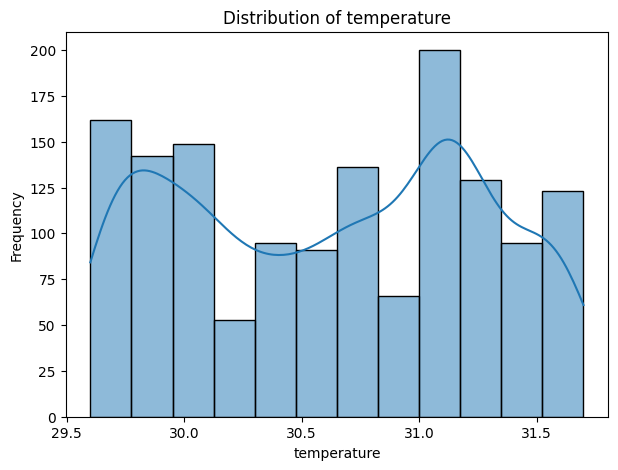

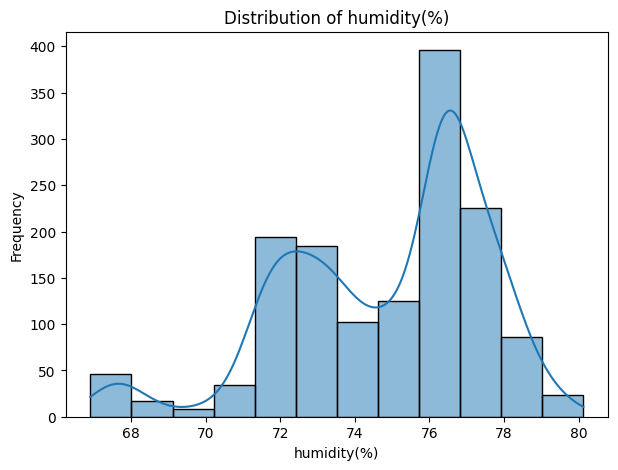

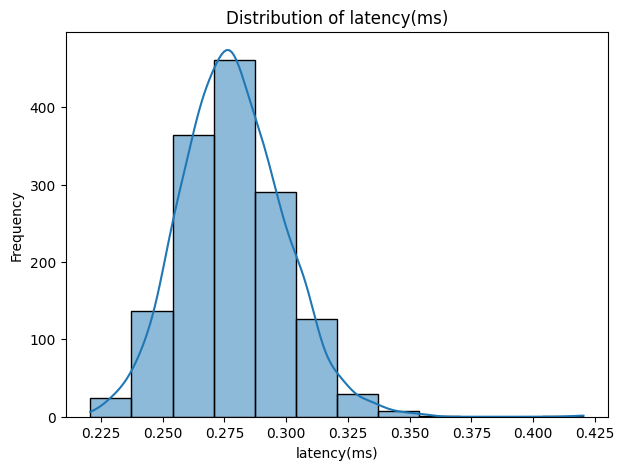

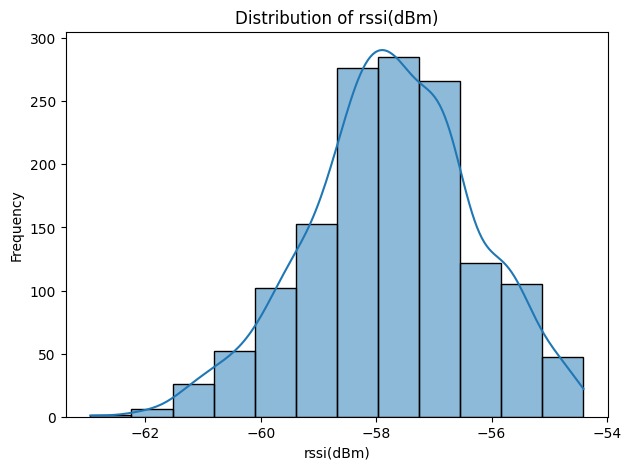

In [16]:
# Exclude the last columns, packet_loss(%) and throughput(bytes/sec)
df_one_day = df_day_one.drop(columns=["packet_loss(%)", "throughput(bytes/sec)", "time_str"])

# Visualize the distribution of the data
for i in df_one_day.columns:
    plt.figure(figsize=(7, 5))
    sns.histplot(data=df_one_day, x=i, bins=12, kde=True)
    plt.xlabel(i)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {i}")
    plt.show()

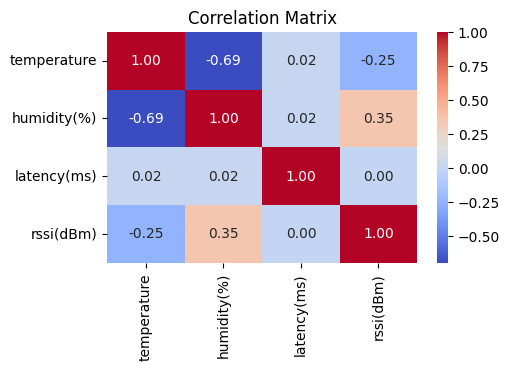

In [17]:
# Plot the correlation matrix with timestamp
plt.figure(figsize=(5, 3))
sns.heatmap(df_one_day.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### ARIMA Model Building

In [18]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils.utils import plot_acf_pacf, check_data_type, build_arima_model

ImportError: cannot import name 'build_arima_model' from 'src.utils.utils' (c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\src\utils\utils.py)

In [ ]:
# Check the data type of the columns
check_data_type(df_one_day)

Column: temperature
Data Type: float64

Column: humidity(%)
Data Type: float64

Column: latency(ms)
Data Type: float64

Column: rssi(dBm)
Data Type: float64



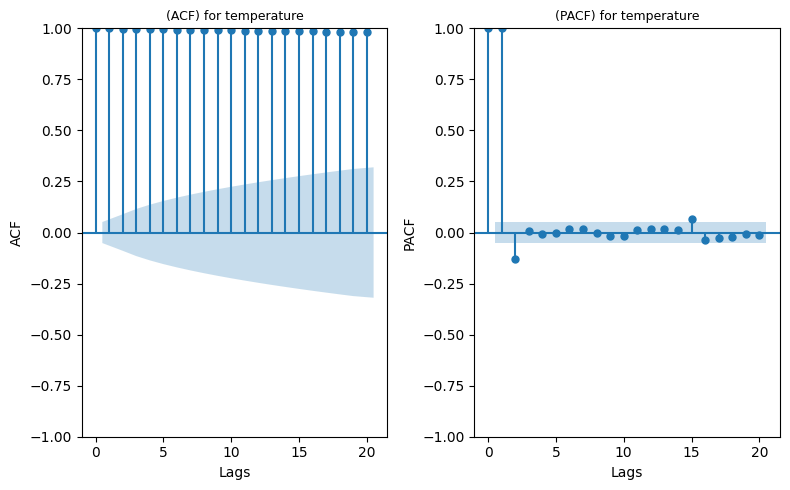

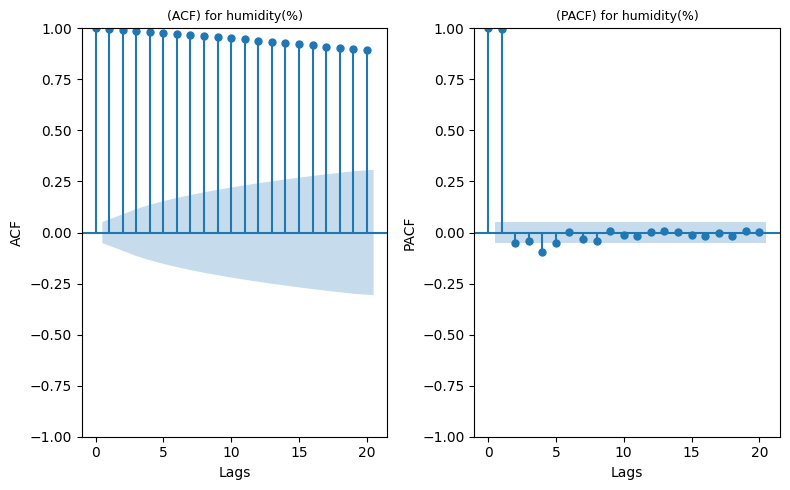

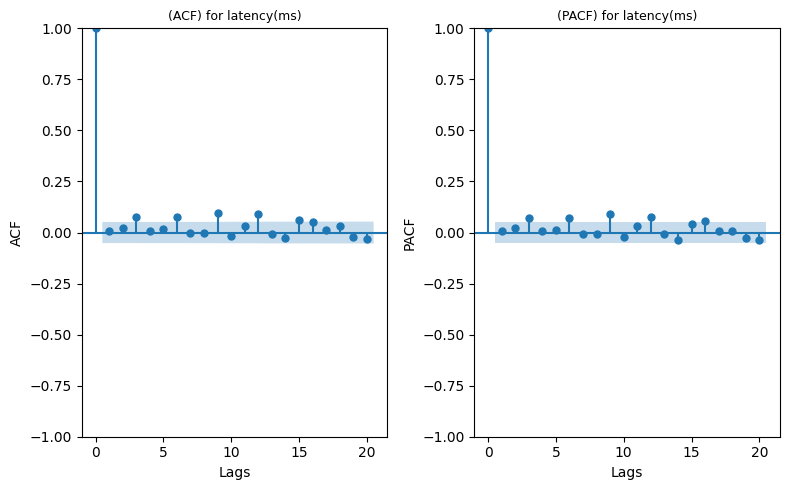

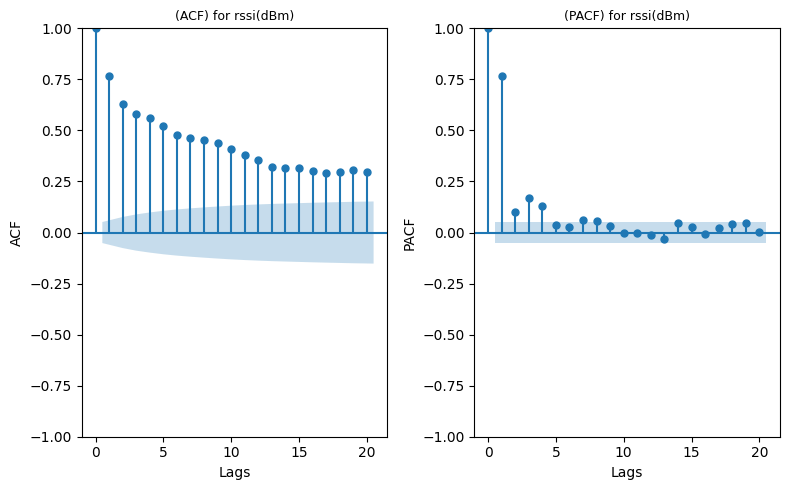

In [ ]:
# Check the temperature stationartity by Plotting the ACF and PACF
for col in df_one_day.columns:
  plot_acf_pacf(df_one_day[col], lags=20, title=col)

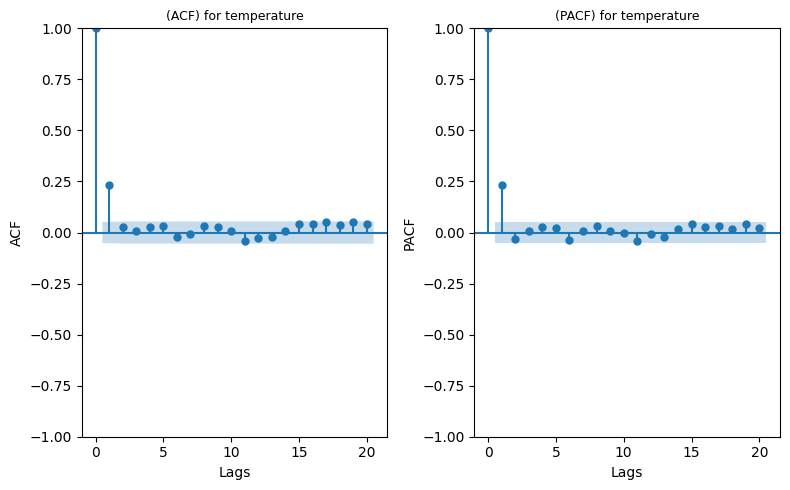

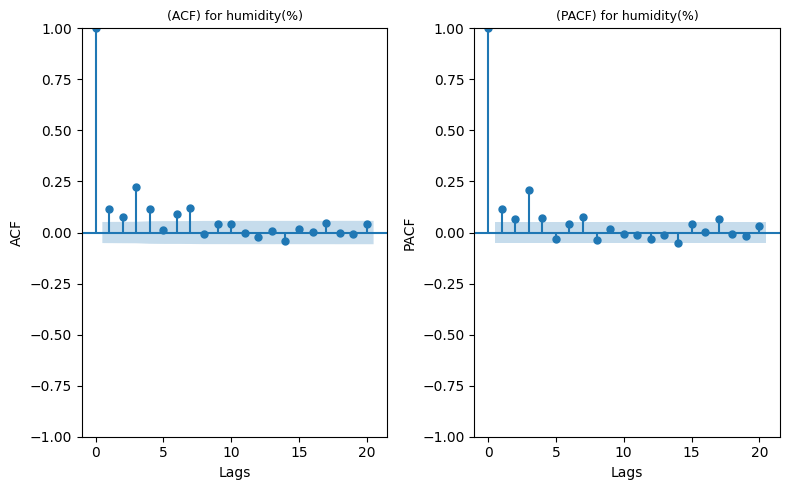

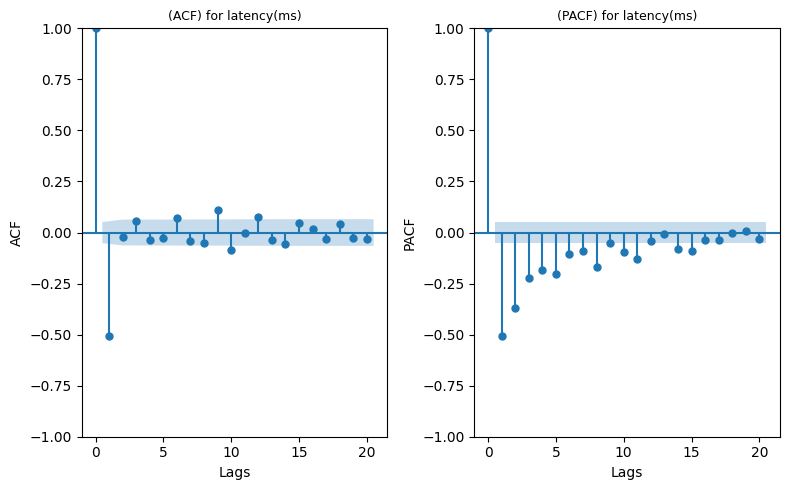

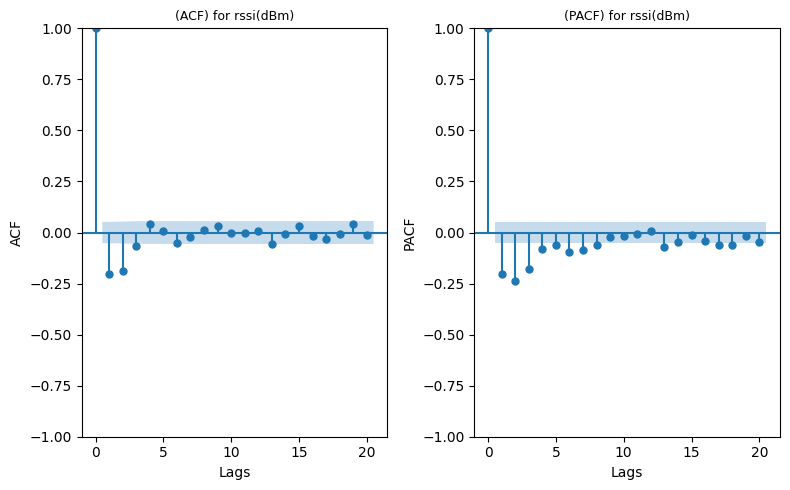

In [ ]:
# Differencing the columns
df_one_day_diff = df_one_day.diff().dropna()

# Plot the ACF and PACF of the differenced data
for col in df_one_day_diff.columns:
  plot_acf_pacf(df_one_day_diff[col], lags=20, title=col)


In [ ]:
# Split data into train and test
train_size = int(len(df_one_day_diff) * 0.8)
train, test = df_one_day_diff.iloc[:train_size], df_one_day_diff.iloc[train_size:]

c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


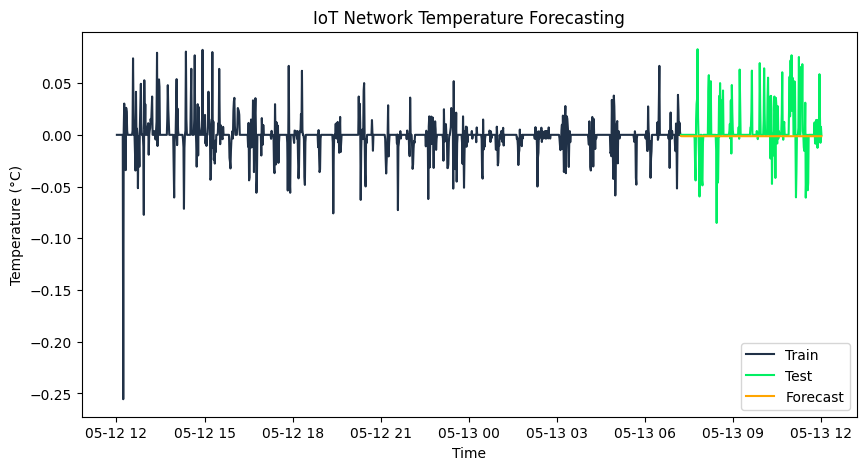

Mean Absolute Error: 0.01
Root Mean Squared Error: 0.02
Mean Squared Error: 0.00


In [ ]:
# Build the ARIMA model for temperature and plot the forecast
from statsmodels.tsa.arima.model import ARIMA
model_temp = ARIMA(train["temperature"], order=(1, 1, 1))
model_fit_temp = model_temp.fit()

# Visualize the model
forecast = model_fit_temp.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(10,5))
plt.plot(train.index, train["temperature"], label='Train', color='#203147')
plt.plot(test.index, test["temperature"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title("IoT Network Temperature Forecasting")
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast_temp = forecast[:len(test)]
test_temp = test["temperature"][:len(forecast)]

mae = mean_absolute_error(test_temp, forecast)
rmse = np.sqrt(mean_squared_error(test_temp, forecast))
mse = mean_squared_error(test_temp, forecast)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


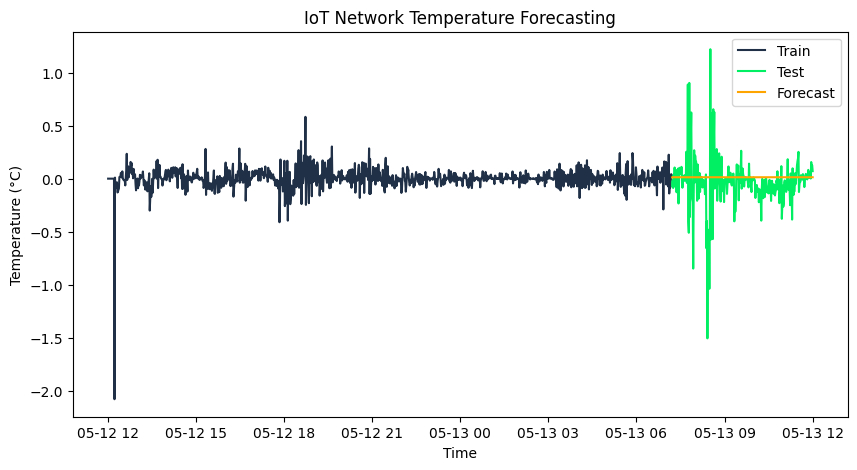

Mean Absolute Error: 0.14
Root Mean Squared Error: 0.24
Mean Squared Error: 0.06


In [ ]:
# Build the ARIMA model for humidity(%) and plot the forecast
from statsmodels.tsa.arima.model import ARIMA
model_hum = ARIMA(train["humidity(%)"], order=(1, 1, 1))
model_fit_hum = model_hum.fit()

# Visualize the model
forecast = model_fit_hum.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(10,5))
plt.plot(train.index, train["humidity(%)"], label='Train', color='#203147')
plt.plot(test.index, test["humidity(%)"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title("Humidity Forecasting")
plt.xlabel('Time')
plt.ylabel('Humoidity (%)')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast_hum = forecast[:len(test)]
test_temp = test["humidity(%)"][:len(forecast)]

mae = mean_absolute_error(test_temp, forecast)
rmse = np.sqrt(mean_squared_error(test_temp, forecast))
mse = mean_squared_error(test_temp, forecast)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimizati

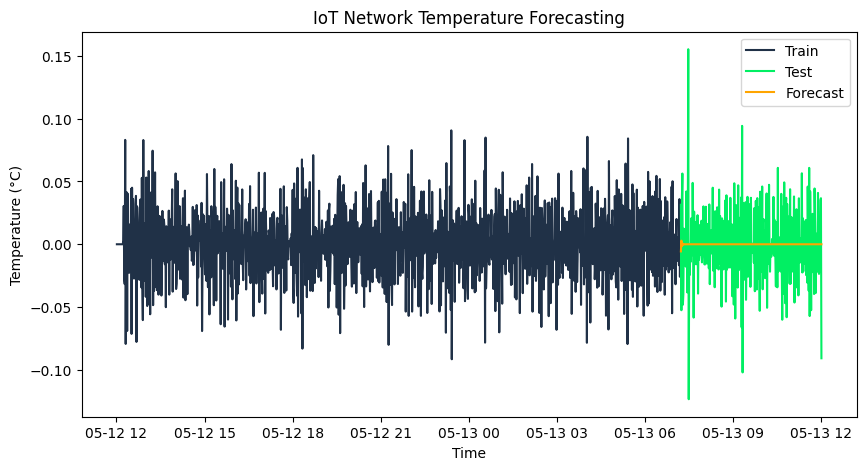

Mean Absolute Error: 0.02
Root Mean Squared Error: 0.03
Mean Squared Error: 0.00


In [ ]:
# Build the ARIMA model for latency(%) and plot the forecast
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train["latency(ms)"], order=(1, 1, 1))
model_fit = model.fit()

# Visualize the model
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(10,5))
plt.plot(train.index, train["latency(ms)"], label='Train', color='#203147')
plt.plot(test.index, test["latency(ms)"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title("IoT Network Temperature Forecasting")
plt.xlabel('Time')
plt.ylabel('Latency (ms)')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast = forecast[:len(test)]
test_temp = test["latency(ms)"][:len(forecast)]

mae = mean_absolute_error(test_temp, forecast)
rmse = np.sqrt(mean_squared_error(test_temp, forecast))
mse = mean_squared_error(test_temp, forecast)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
c:\Kuliah\Semester 6\Signal Processing and Multimedia Services\Project\pslm-project\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


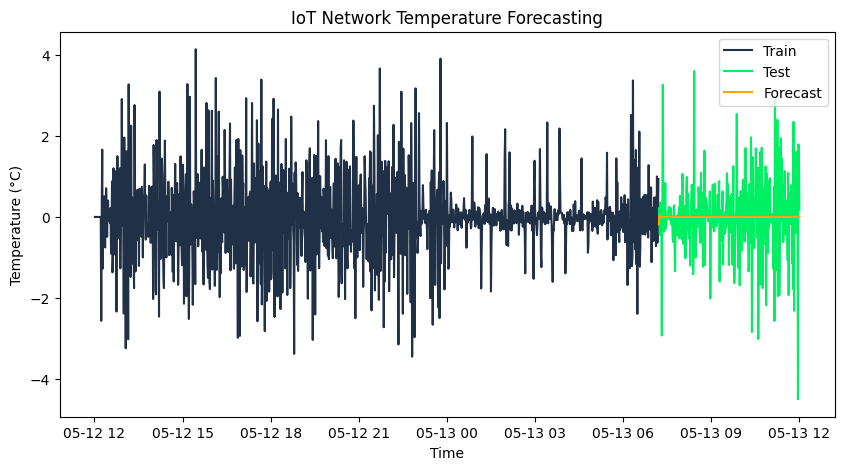

Mean Absolute Error: 0.64
Root Mean Squared Error: 0.96
Mean Squared Error: 0.91


In [ ]:
# Build the ARIMA model for latency(%) and plot the forecast
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train["rssi(dBm)"], order=(1, 1, 1))
model_fit = model.fit()

# Visualize the model
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(10,5))
plt.plot(train.index, train["rssi(dBm)"], label='Train', color='#203147')
plt.plot(test.index, test["rssi(dBm)"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title("IoT Network Temperature Forecasting")
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast = forecast[:len(test)]
test_temp = test["rssi(dBm)"][:len(forecast)]

mae = mean_absolute_error(test_temp, forecast)
rmse = np.sqrt(mean_squared_error(test_temp, forecast))
mse = mean_squared_error(test_temp, forecast)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Squared Error: {mse:.2f}")